# Machine Learning: Feature Importance, Decision Tree, Random Forest, Ridge, Lasso, Elastic Net Regression and Gradiant Boosting on Housing Prices

In [158]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
import matplotlib.pyplot as plt 
import sklearn.model_selection as ms
pd.set_option('display.max_columns', 85)
pd.set_option('display.max_rows', 85)
import random

## Data Preparation

In [159]:
# Loading up Data Frames from CSV files
house_features = pd.read_csv('EDA_Final.csv')
nominal = pd.read_csv('Nominal.csv')
ordinal = pd.read_csv('Ordinal.csv')
numeric = pd.read_csv('Numeric.csv').drop(columns='SalePrice')
Y = np.log(pd.read_csv('SalePrice_final.csv')) # Takes away skewing
Y = Y.SalePrice # removes index and prepped to be used as response variable.

In [160]:
# This is used to make the grid_tree_search easier. Thanks Aiko.

def get_error(X_train, Y_train, X_test, Y_test, model, show = True):
    model.fit(X_train, Y_train)
    train_error = 1 - model.score(X_train, Y_train)
    test_error  = 1 - model.score(X_test, Y_test)
    if show:
        print("The training error is: %.5f" %train_error)
        print("The test error is: %.5f" %test_error)
    return [train_error, test_error]

### Correlation Check and Feature Removal

In [161]:
# Checking for Correlation
def correlation_generator(correlation):
    d =dict()
    for i in range(correlation.shape[0]//2):
        for j in range(correlation.shape[1]):
            if i!=j and correlation.iloc[i,j]>0.7:
                t1 = correlation.index[i]
                t2 = correlation.columns[j]
                if t1 != t2:
                    t = t1 +','+t2
                    d[t] = correlation.iloc[i,j]    
    return(d)

num_ord_corr = pd.concat([numeric,ordinal], axis=1).corr()
print('Numerical + Ordinal:', correlation_generator(num_ord_corr), sep='\n')



Numerical + Ordinal:
{'OverallQual,ExterQual': 0.7262784907641455, 'TotalBsmtSF,X1stFlrSF': 0.8195299750050355, 'X1stFlrSF,TotalBsmtSF': 0.8195299750050355, 'GrLivArea,TotRmsAbvGrd': 0.8254893743088377, 'TotRmsAbvGrd,GrLivArea': 0.8254893743088377}


In [180]:
# Remove highly correlated values:
numeric_v2 = numeric.drop(columns=['TotalBsmtSF', 'GrLivArea'])
ordinal_v2 = ordinal.drop(columns='ExterQual')

num_ord_corr_v2 = pd.concat([numeric_v2, ordinal_v2], axis=1).corr()
#print('Numerical + Ordinal:', correlation_generator(num_ord_corr_v2), sep='\n')
# Removing FireplaceQu
ordinal_v3 = ordinal_v2.drop(columns='FireplaceQu')

print(correlation_generator(pd.concat([numeric_v2,ordinal_v3], axis=1).corr()))


{}


In [162]:
# Concatenate the dataframes together
nominal_dummified = pd.get_dummies(nominal, drop_first=True)
X = pd.concat([nominal_dummified, ordinal_v3, numeric_v2], axis=1)

## Modeling

### Tree Model

In [163]:
# Tree Modeling
random.seed(10)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train, Y_train)

print("Training error:", str(1-tree_model.score(X_train, Y_train)), sep='\n')
print("Test error:",str(1-tree_model.score(X_test, Y_test)), sep='\n')
print("R^2 Training:", str(tree_model.score(X_train, Y_train)), sep='\n')
print("R^2 Test:", str(tree_model.score(X_test, Y_test)), sep='\n')
print("Mean Squared Error:", mean_squared_error(Y_test,tree_model.predict(X_test)), sep='\n')

Training error:
0.0
Test error:
0.31396774375982395
R^2 Training:
1.0
R^2 Test:
0.686032256240176
Mean Squared Error:
0.04753466676250025


Text(0.5, 0, 'Importance of Feature')

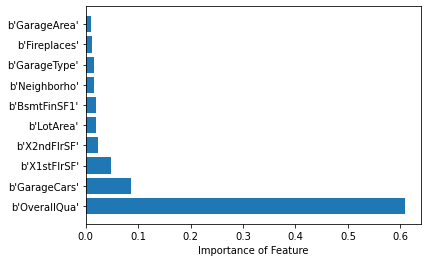

In [164]:
# Calculates the important features.
feature_importance = list(zip(X.columns, tree_model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]

# This plots the top 10 features based on importance
featureNames, featureScores = zip(*list(feature_sort))
plt.barh(range(0,10), featureScores[0:10], tick_label=featureNames[0:10])
plt.xlabel('Importance of Feature')

In [165]:
# This changes the depth of the tree to see which is the best. This is just calculations.
grid_para_tree = [
    {'max_depth': range(1, 31)}
]

tree_model.set_params(random_state=0)
grid_search_tree = ms.GridSearchCV(tree_model, grid_para_tree, cv=5, n_jobs=-1, return_train_score=True)
grid_search_tree.fit(X_train, Y_train)


# This lets us know the best score.
print('Least Amount of Error:', 1 - grid_search_tree.best_score_, sep='\n')
print('Best Depth:',grid_search_tree.best_index_, sep='\n')

Least Amount of Error:
0.29384228734661666
Best Depth:
6


Text(0.5, 0, 'depth')

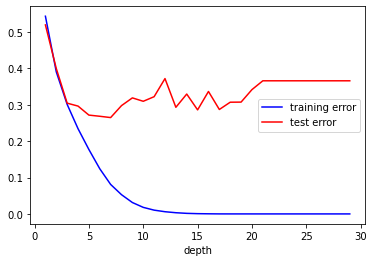

In [166]:
# This plots where we decide to choose (6)

depth  = range(1, 30)
tree_train = []
tree_test = []
for i in depth:
    tree_model.set_params(max_depth = i)
    error = get_error(X_train, Y_train, X_test, Y_test, tree_model, show=False)
    tree_train.append(error[0])
    tree_test.append(error[1])


plt.plot(depth, tree_train, c = 'blue', label='training error')
plt.plot(depth, tree_test, c = 'red', label='test error')
plt.legend(loc=7)
plt.xlabel('depth')

### Forest Model

In [167]:
# Forest Modeling

randomForest = ensemble.RandomForestRegressor()
randomForest.fit(X_train, Y_train) 

print("The training error is: %.5f" % (1 - randomForest.score(X_train, Y_train)))
print("The test error is: %.5f" % (1 - randomForest.score(X_test, Y_test)))
print("R^2 Training:", str(tree_model.score(X_train, Y_train)), sep='\n')
print("R^2 Test:", str(tree_model.score(X_test, Y_test)), sep='\n')
print("Mean Squared Error:", mean_squared_error(Y_test,randomForest.predict(X_test)), sep='\n')

# Random forest does much better but still over fitting.

The training error is: 0.01969
The test error is: 0.14216
R^2 Training:
1.0
R^2 Test:
0.6343337852749056
Mean Squared Error:
0.02152305295931137


Text(0.5, 0, 'Importance of Feature')

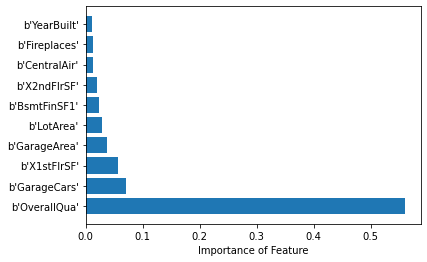

In [168]:
# Calculates the important features for Forests
feature_importance = list(zip(X.columns, randomForest.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]

# This plots the top 10 features based on importance
featureNames, featureScores = zip(*list(feature_sort))
plt.barh(range(0,10), featureScores[0:10], tick_label=featureNames[0:10])
plt.xlabel('Importance of Feature')

# We see that there are few differences in which features are the most important

### Ridge, Lasso and Elastic Net Model

In [169]:
# Linear Regression with Ridge, Lasso and Elastic net
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
ridge = Ridge()
lasso = Lasso()
net   = ElasticNet()

In [170]:
# Ridge
ridge.set_params(alpha=1.0, normalize=True)
ridge.fit(X_train, Y_train)
print('Training Score:', ridge.score(X_train, Y_train), sep='\n')
print('Test Score:', ridge.score(X_test, Y_test), sep='\n')
print("Mean Squared Error:", mean_squared_error(Y_test, ridge.predict(X_test)), sep='\n')

Training Score:
0.89507712521096
Test Score:
0.7788109064071534
Mean Squared Error:
0.03348799379683556


In [171]:
# Choosing from a range of alphas to see what is a good value
coefs = []
intercepts = []
R2_train  = []
R2_test = []
alphaRange = np.linspace(1,30,200)
for alpha in alphaRange:
    ridge.set_params(alpha=alpha)  
    ridge.fit(X_train, Y_train)
    intercepts.append(ridge.intercept_)
    coefs.append(ridge.coef_)
    R2_train.append(ridge.score(X_train, Y_train))
    R2_test.append(ridge.score(X_test, Y_test))

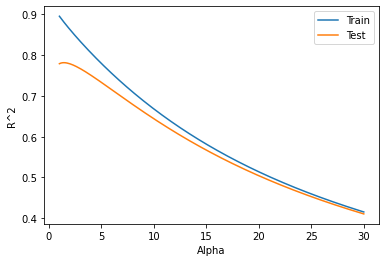

In [172]:
# Using the plot to estimate a good alpha
plt.plot(alphaRange, R2_train)
plt.plot(alphaRange, R2_test)
plt.legend(('Train', 'Test'))
plt.xlabel('Alpha')
plt.ylabel('R^2')
plt.show()
# Looks like our model overfits and always stays above test. A small alpha of about 1.4 gives us the best result.

In [173]:
# Lasso
lasso.set_params(alpha=1, normalize=True)
lasso.fit(X_train, Y_train)
print('Training Score:', lasso.score(X_train, Y_train), sep='\n')
print('Testing Score:', lasso.score(X_test, Y_test), sep='\n')
print("Mean Squared Error:", mean_squared_error(Y_test, lasso.predict(X_test)), sep='\n')
# Clearly, alpha was too large.

Training Score:
0.0
Testing Score:
-7.992313858662392e-05
Mean Squared Error:
0.15141194223641363


In [174]:
# Choosing from a range of alphas to see what is a good value
coefs = []
intercepts = []
R2_train  = []
R2_test = []
alphaRange = np.linspace(1e-3,0.01,200)
for alpha in alphaRange:
    lasso.set_params(alpha=alpha)  
    lasso.fit(X_train, Y_train)
    intercepts.append(lasso.intercept_)
    coefs.append(lasso.coef_)
    R2_train.append(lasso.score(X_train, Y_train))
    R2_test.append(lasso.score(X_test, Y_test))

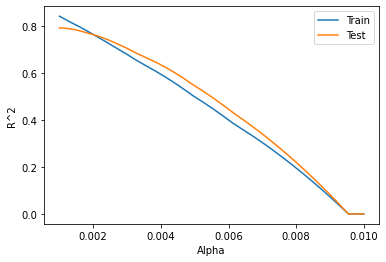

In [175]:
# Using the plot to find a good alpha.
plt.plot(alphaRange, R2_train)
plt.plot(alphaRange, R2_test)
plt.legend(('Train', 'Test'))
plt.xlabel('Alpha')
plt.ylabel('R^2')
plt.show()
# We see that it crosses at about 0.001. So it is a good alpha to choose from.

In [176]:
# Lasso Redone
lasso.set_params(alpha=0.002, normalize=True)
lasso.fit(X_train, Y_train)
print('Training Score:', lasso.score(X_train, Y_train), sep='\n')
print('Testing Score:', lasso.score(X_test, Y_test), sep='\n')

Training Score:
0.7660730217745343
Testing Score:
0.7650797240350684


In [177]:
# Elastic Net
net.set_params(alpha=1, normalize=True)
net.fit(X_train, Y_train)
print('Training Score:', net.score(X_train, Y_train), sep='\n')
print('Testing Score:', net.score(X_test, Y_test), sep='\n')
print("Mean Squared Error:", mean_squared_error(Y_test, net.predict(X_test)), sep='\n')

# Needs a smaller alpha.

Training Score:
0.0
Testing Score:
-7.992313858662392e-05
Mean Squared Error:
0.15141194223641363


In [178]:
# Test out some alphas.
coefs = []
intercepts = []
R2_train  = []
R2_test = []
alphaRange = np.linspace(1e-3,0.01,200)
for alpha in alphaRange:
    net.set_params(alpha=alpha)  
    net.fit(X_train, Y_train)
    intercepts.append(net.intercept_)
    coefs.append(net.coef_)
    R2_train.append(net.score(X_train, Y_train))
    R2_test.append(net.score(X_test, Y_test))

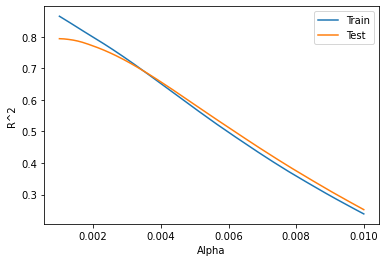

In [179]:
# Plotting alphas compared to R^2
plt.plot(alphaRange, R2_train)
plt.plot(alphaRange, R2_test)
plt.legend(('Train', 'Test'))
plt.xlabel('Alpha')
plt.ylabel('R^2')
plt.show()
# Looks like 0.003 is a good value

In [181]:
# Elastic Net Redone.
net.set_params(alpha=0.003, normalize=True)
net.fit(X_train, Y_train)
print('Training Score:', net.score(X_train, Y_train), sep='\n')
print('Testing Score:', net.score(X_test, Y_test), sep='\n')
print("Mean Squared Error:", mean_squared_error(Y_test, net.predict(X_test)), sep='\n')

Training Score:
0.7289483473056924
Testing Score:
0.7220858063058815
Mean Squared Error:
0.042076164983128196


In [182]:
gbm = GradientBoostingRegressor()
gbm.fit(X_train, Y_train)
print('Training Score:', gbm.score(X_train, Y_train), sep='\n')
print('Testing Score:', gbm.score(X_test, Y_test), sep='\n')
print("Mean Squared Error:", mean_squared_error(Y_test, gbm.predict(X_test)), sep='\n')

Training Score:
0.9555682499624993
Testing Score:
0.8692663680525647
Mean Squared Error:
0.019793051206007033


In [183]:
# Add Learning rate:
learn_rate = np.linspace(0.001, 0.02, 10)
R2_train = []
R2_test = []
for rate in learn_rate:
    gbm.set_params(learning_rate=rate)
    gbm.fit(X_train, Y_train)
    R2_train.append(gbm.score(X_train, Y_train))
    R2_test.append(gbm.score(X_test, Y_test))

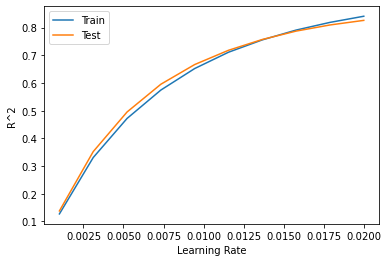

In [184]:
plt.plot(learn_rate, R2_train)
plt.plot(learn_rate, R2_test)
plt.legend(('Train', 'Test'))
plt.xlabel('Learning Rate')
plt.ylabel('R^2')
plt.show()
# Looks like 0.0150 is a good learning rate or somewhere in that area.

In [185]:
gbm.set_params(learning_rate=0.0150)
gbm.fit(X_train, Y_train)
print('Training Score:', gbm.score(X_train, Y_train), sep='\n')
print('Testing Score:', gbm.score(X_test, Y_test), sep='\n')
print("Mean Squared Error:", mean_squared_error(Y_test, gbm.predict(X_test)), sep='\n')

Training Score:
0.7786362966093809
Testing Score:
0.7771931920227104
Mean Squared Error:
0.03373291549885673


In [186]:
max_depth = range(1,10)
R2_train = []
R2_test = []
for depth in max_depth:
    gbm.set_params(learning_rate=0.0150, max_depth=depth)
    gbm.fit(X_train, Y_train)
    R2_train.append(gbm.score(X_train, Y_train))
    R2_test.append(gbm.score(X_test, Y_test))

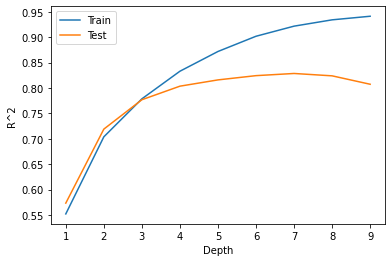

In [187]:
plt.plot(max_depth, R2_train)
plt.plot(max_depth, R2_test)
plt.legend(('Train', 'Test'))
plt.xlabel('Depth')
plt.ylabel('R^2')
plt.show()
# Max Depth 3.

In [188]:
gbm.set_params(learning_rate=0.0150, max_depth=3)
gbm.fit(X_train, Y_train)
print('Training Score:', gbm.score(X_train, Y_train), sep='\n')
print('Testing Score:', gbm.score(X_test, Y_test), sep='\n')
print("Mean Squared Error:", mean_squared_error(Y_test, gbm.predict(X_test)), sep='\n')

Training Score:
0.7786362966093809
Testing Score:
0.7771931920227104
Mean Squared Error:
0.03373291549885673


In [189]:
steps = range(50, 300, 10)
R2_train = []
R2_test = []
for estimators in steps:
    gbm.set_params(learning_rate=0.0150, max_depth=3, n_estimators=estimators)
    gbm.fit(X_train, Y_train)
    R2_train.append(gbm.score(X_train, Y_train))
    R2_test.append(gbm.score(X_test, Y_test))

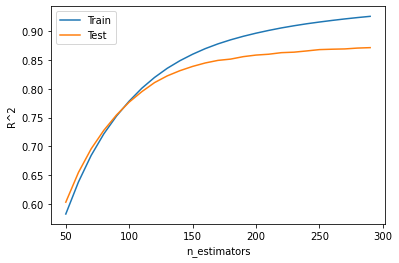

In [190]:
plt.plot(steps, R2_train)
plt.plot(steps, R2_test)
plt.legend(('Train', 'Test'))
plt.xlabel('n_estimators')
plt.ylabel('R^2')
plt.show()

In [191]:
gbm.set_params(learning_rate=0.0150, max_depth=3, n_estimators=140)
gbm.fit(X_train, Y_train)
print('Training Score:', gbm.score(X_train, Y_train), sep='\n')
print('Testing Score:', gbm.score(X_test, Y_test), sep='\n')
print("Mean Squared Error:", mean_squared_error(Y_test, gbm.predict(X_test)), sep='\n')

Training Score:
0.8489025529822125
Testing Score:
0.8307495273289103
Mean Squared Error:
0.025624494801511508


## Conclusion
The best result from this was the gradient boosting and is perhaps the most reliable. It seems that overall quality of the house is what matters the most for the sales price as well as number of cars that can fit in the garage. We can essentially predict about 80% of the time, the housing sale price.